# Prepare some things
## Load some modules

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from keras.utils import to_categorical

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.metrics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../')
from models import get_autoencoder_model, get_dec_model, get_vae_model, get_clustering_vae_model, get_vade_models, compute_p, compute_delta
from clustering_metrics import evaluate_model, evaluate_clustering
from draw_embeddings import draw_embeddings, draw_clusters_assignments

## Load the dataset

In [3]:
codebook = pd.read_csv("ExposomeChallengeData/datasets/codebook.csv", index_col=0)
phenotype = pd.read_csv("ExposomeChallengeData/datasets/phenotype.csv", index_col=0)
exposome = pd.read_csv("ExposomeChallengeData/datasets/exposome.csv", index_col=0)
covariates = pd.read_csv("ExposomeChallengeData/datasets/covariates.csv", index_col=0)

metabol_serum_exprs = pd.read_csv("ExposomeChallengeData/datasets/metabol_serum_exprs.csv", index_col=0).T
metabol_serum_pdata = pd.read_csv("ExposomeChallengeData/datasets/metabol_serum_pData.csv", index_col=0)
metabol_serum_fdata = pd.read_csv("ExposomeChallengeData/datasets/metabol_serum_fData.csv", index_col=0)

metabol_urine_exprs = pd.read_csv("ExposomeChallengeData/datasets/metabol_urine_exprs.csv", index_col=0).T
metabol_urine_pdata = pd.read_csv("ExposomeChallengeData/datasets/metabol_urine_pData.csv", index_col=0)
metabol_urine_fdata = pd.read_csv("ExposomeChallengeData/datasets/metabol_urine_fData.csv", index_col=0)

proteome_exprs = pd.read_csv("ExposomeChallengeData/datasets/proteome_exprs.csv", index_col=0).T
proteome_pdata = pd.read_csv("ExposomeChallengeData/datasets/proteome_pData.csv", index_col=0)
proteome_fdata = pd.read_csv("ExposomeChallengeData/datasets/proteome_fData.csv", index_col=0)

## Join all the metabolomic data

In [4]:
metabol_exprs = pd.concat([metabol_serum_exprs.rename('serum_{}'.format, axis=1),
                           metabol_urine_exprs.rename('urine_{}'.format, axis=1)], axis=1)
metabol_exprs

,serum_metab_1,serum_metab_2,serum_metab_3,serum_metab_4,serum_metab_5,serum_metab_6,serum_metab_7,serum_metab_8,serum_metab_9,serum_metab_10,...,urine_metab_35,urine_metab_36,urine_metab_37,urine_metab_38,urine_metab_39,urine_metab_40,urine_metab_41,urine_metab_42,urine_metab_43,urine_metab_44
430,-2.145605,-0.714302,8.599913,0.552377,7.051481,5.785289,3.747387,5.070389,-1.867752,-2.771027,...,5.185867,5.057450,12.117805,2.906891,4.446256,4.529821,3.877744,-0.152003,3.087463,2.459432
1187,-0.685014,-0.368663,9.154818,-1.334607,6.894211,5.806066,4.257765,5.083213,-2.300448,-3.418890,...,4.977280,7.870365,11.985735,-4.321928,4.990955,4.738768,-0.321928,0.263034,2.944858,2.584963
940,-0.685014,-0.361231,8.954196,-0.127368,7.104861,5.859224,4.345538,5.918863,-1.965784,-3.403542,...,4.986411,5.040016,12.200040,-4.321928,4.104337,4.385431,3.817623,-4.321928,3.744161,2.981853
936,-0.194295,-0.339163,8.535275,-0.618163,7.007308,5.950702,4.242603,5.405992,-1.894322,-2.841663,...,4.827819,6.697663,11.570899,-2.321928,4.765535,3.292782,3.017922,-4.321928,3.990955,3.523562
788,-1.960160,-0.346481,8.727920,-0.797112,6.895424,5.950702,4.884109,5.388878,-1.552156,-2.454032,...,4.754888,5.221104,11.679524,-0.321928,3.700440,4.781360,3.201634,-0.321928,2.765535,2.944858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
680,2.359240,-0.346481,8.797662,0.065572,6.687201,5.912889,3.820690,5.469235,-1.657445,-2.666576,...,4.419539,4.371559,12.044155,4.224966,5.189825,3.837943,3.336283,-4.321928,2.035624,3.485427
634,1.299245,-0.719044,8.661778,-1.144010,7.104861,5.881420,3.508429,5.402586,-1.988504,-2.971431,...,5.944858,4.277985,12.047533,3.807355,5.247928,4.343408,3.419539,-4.321928,4.802193,2.827819
574,-0.739372,-0.472930,8.714246,-1.199255,6.996050,5.390599,4.106851,5.378512,-2.171368,-3.258425,...,4.596935,5.894818,11.645073,3.104337,4.504620,3.536053,4.095924,-4.321928,3.786596,4.336283
840,-1.522841,-0.435378,8.643856,-0.154410,6.774128,5.499846,3.880686,5.442943,-2.017417,-3.204233,...,5.961160,5.705978,12.249321,2.678072,4.542258,4.070389,3.000000,2.000000,3.776104,2.405992


In [5]:
# Standarize data
from sklearn.preprocessing import StandardScaler
metabol_exprs = StandardScaler().fit_transform(metabol_exprs)
metabol_exprs

array([[-1.35249543, -1.3788379 , -0.23468211, ...,  0.6926893 ,
        -0.55775124, -0.37477451],
       [-0.05521341,  0.59074232,  1.79711728, ...,  0.85292768,
        -0.68645307, -0.25864268],
       [-0.05521341,  0.6330915 ,  1.06253558, ..., -0.91724247,
         0.0349252 ,  0.10853056],
       ...,
       [-0.10349412, -0.0034089 ,  0.1839498 , ..., -0.91724247,
         0.07322343,  1.3615491 ],
       [-0.79936263,  0.2105748 , -0.07378247, ...,  1.52353832,
         0.06375396, -0.42421253],
       [-1.74016756, -0.68095671, -1.57587362, ..., -0.91724247,
        -1.78967388,  0.65531403]])

In [6]:
# Number of data points
np.multiply(*metabol_exprs.shape)

254592

## Categorical data (possible groups to compare)

The phenotype data has two categorical variables:
- has asthma (2 groups)
- bmi category (4 groups)

<BarContainer object of 2 artists>

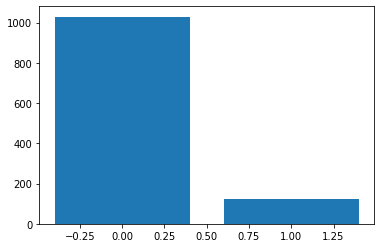

In [7]:
# Asthma groups distribution:
asthma_class = phenotype['hs_asthma']
asthma_counts = asthma_class.value_counts()
plt.bar(asthma_counts.index, asthma_counts)

<BarContainer object of 4 artists>

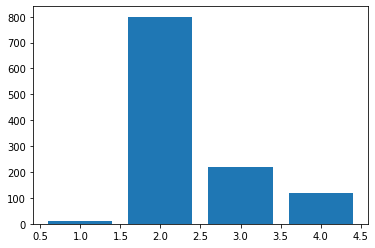

In [8]:
# BMI groups distribution:
bmi_class = phenotype['hs_bmi_c_cat']
bmi_counts = bmi_class.value_counts()
plt.bar(bmi_counts.index, bmi_counts)

# Raw data

## K-means

Try fitting K-means with a range of clusters. Compute the silhouette as a metric of QC. Plot the results.

In [116]:
MIN_K = 2
MAX_K = 10

ks = np.arange(MIN_K, MAX_K)
sils = []
for k in ks:
    kmeans = KMeans(n_clusters=k, n_init=30)
    labels = kmeans.fit_predict(metabol_exprs)
    sils.append(sklearn.metrics.silhouette_score(metabol_exprs, labels))

plt.plot(sils)
plt.xticks(np.arange(0, len(ks)), ks, rotation=90)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette');

The best result is achieved with K=2. K=3 and K=4 may be also good.

Let's plot the 2D t-SNE representation for theese three values.

In [118]:
tsne = TSNE(n_components=2, init='pca')
raw_data_tsne = tsne.fit_transform(metabol_exprs)

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


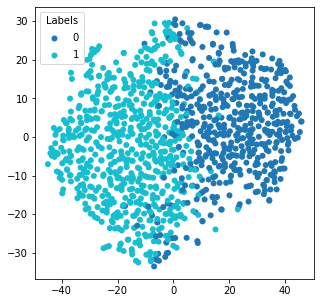

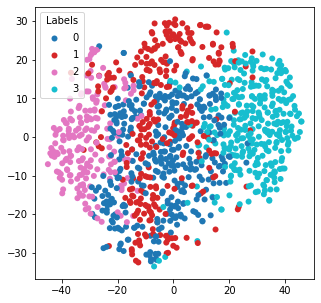

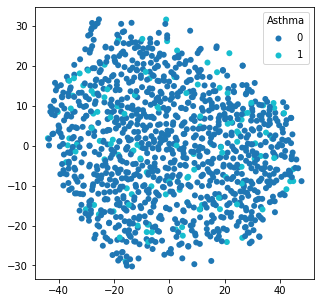

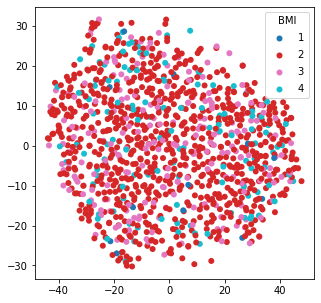

In [222]:
for k in (2,4):
    kmeans = KMeans(n_clusters=k, n_init=30)
    labels = kmeans.fit_predict(metabol_exprs)
    draw_embeddings(raw_data_tsne, labels, alpha=1, figsize=(5,5))
    
draw_embeddings(z_pca_tsne, asthma_class, alpha=1, figsize=(5,5), legend_title="Asthma")
draw_embeddings(z_pca_tsne, bmi_class, alpha=1, figsize=(5,5), legend_title="BMI")

## GMM

In [198]:
MIN_K = 2
MAX_K = 10

ks = np.arange(MIN_K, MAX_K)
sils = []
for k in ks:
    gmm = GaussianMixture(n_components=k, covariance_type='diag', n_init=10)
    labels = gmm.fit_predict(metabol_exprs)
    sils.append(sklearn.metrics.silhouette_score(metabol_exprs, labels))

plt.plot(sils)
plt.xticks(np.arange(0, len(ks)), ks, rotation=90)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette');

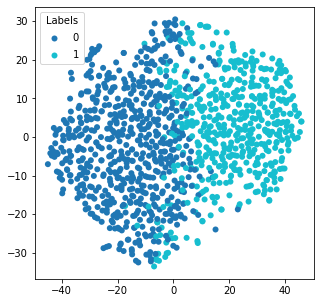

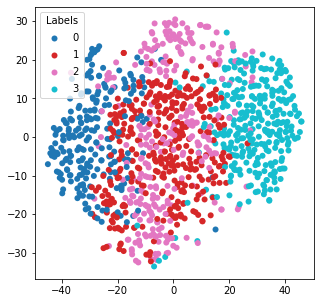

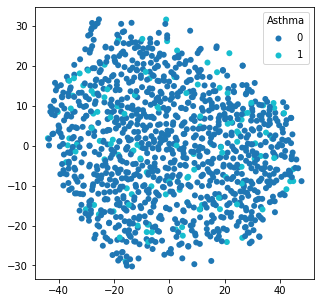

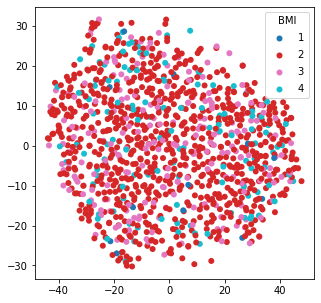

In [221]:
for k in (2,4):
    gmm = GaussianMixture(n_components=k, covariance_type='diag', n_init=10)
    labels = gmm.fit_predict(metabol_exprs)
    draw_embeddings(raw_data_tsne, labels, alpha=1, figsize=(5,5))

draw_embeddings(z_pca_tsne, asthma_class, alpha=1, figsize=(5,5), legend_title="Asthma")
draw_embeddings(z_pca_tsne, bmi_class, alpha=1, figsize=(5,5), legend_title="BMI")

# PCA

In [112]:
# Find the number of PCs to explain 0.95 of the variance:
pca = PCA(n_components=0.95)
pca.fit(metabol_exprs)

PCA(n_components=0.95)

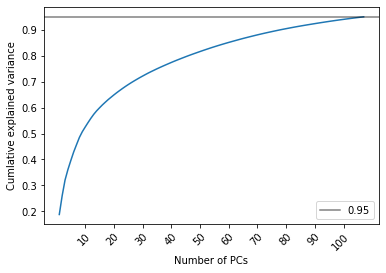

In [113]:
plt.plot(np.arange(0, pca.n_components_),np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y = 0.95, color='black', linestyle='-', alpha=0.5, label="0.95")
plt.xticks(np.arange(9, pca.n_components_, 10), np.arange(10, pca.n_components_+1, 10), rotation=45, rotation_mode="anchor", ha='right')
plt.xlabel('Number of PCs')
plt.ylabel('Cumlative explained variance');
plt.legend();

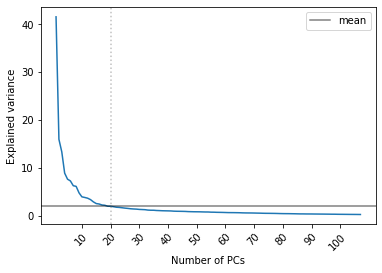

In [114]:
N_PCS = 20

plt.plot(np.arange(0, pca.n_components_), pca.explained_variance_)
plt.axhline(y = np.mean(pca.explained_variance_), color='black', linestyle='-', alpha=0.5, label="mean")
plt.axvline(x = N_PCS-1, color='grey', linestyle='dotted', alpha=0.5)
plt.xticks(np.arange(9, pca.n_components_, 10), np.arange(10, pca.n_components_+1, 10), rotation=45, rotation_mode="anchor", ha='right')
plt.xlabel('Number of PCs')
plt.ylabel('Explained variance');
plt.legend();

We need around 100 PCs to explain 0.95 of the variance. We'll take the first 20 PCs, since there seems to be an elbow on the second plot around this value, and they explain at least the mean explained variance.

In [115]:
z_pca = pca.transform(metabol_exprs)[:,0:N_PCS]

## K-means

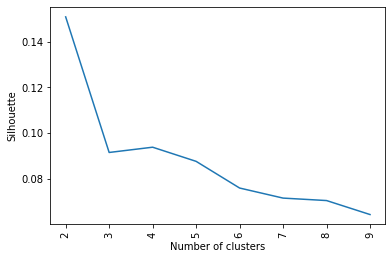

In [116]:
MIN_K = 2
MAX_K = 10

ks = np.arange(MIN_K, MAX_K)
sils = []
for k in ks:
    kmeans = KMeans(n_clusters=k, n_init=30)
    labels = kmeans.fit_predict(z_pca)
    sils.append(sklearn.metrics.silhouette_score(z_pca, labels))

plt.plot(sils)
plt.xticks(np.arange(0, len(ks)), ks, rotation=90)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette');

In [117]:
tsne = TSNE(n_components=2, init='pca')
z_pca_tsne = tsne.fit_transform(z_pca)

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


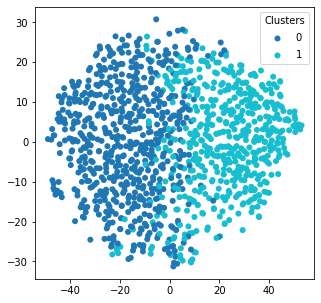

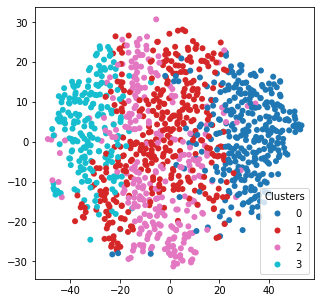

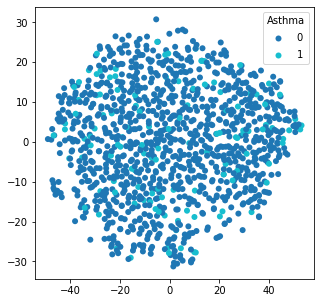

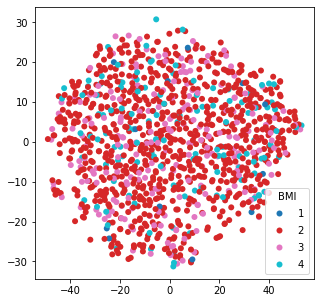

In [119]:
for k in (2,4):
    kmeans = KMeans(n_clusters=k, n_init=30)
    c_pca_kmeans = kmeans.fit_predict(z_pca)
    draw_embeddings(z_pca_tsne, c_pca_kmeans, alpha=1, figsize=(5,5), legend_title="Clusters")

draw_embeddings(z_pca_tsne, asthma_class, alpha=1, figsize=(5,5), legend_title="Asthma")
draw_embeddings(z_pca_tsne, bmi_class, alpha=1, figsize=(5,5), legend_title="BMI")

## GMM

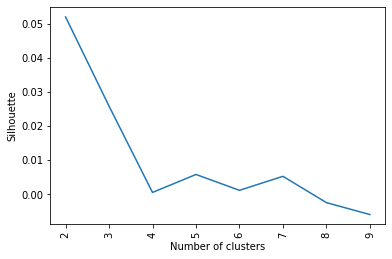

In [237]:
MIN_K = 2
MAX_K = 10

ks = np.arange(MIN_K, MAX_K)
sils = []
for k in ks:
    gmm = GaussianMixture(n_components=k, covariance_type='diag', n_init=10)
    labels = gmm.fit_predict(z_pca)
    sils.append(sklearn.metrics.silhouette_score(z_pca, labels))

plt.plot(sils)
plt.xticks(np.arange(0, len(ks)), ks, rotation=90)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette');

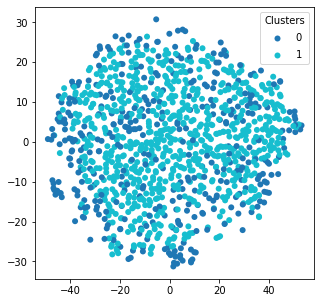

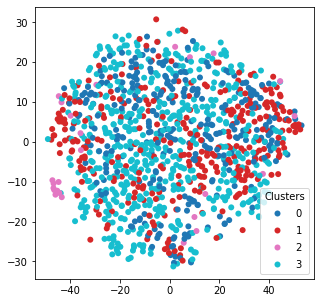

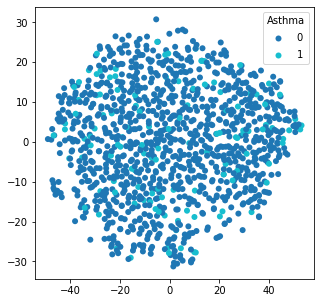

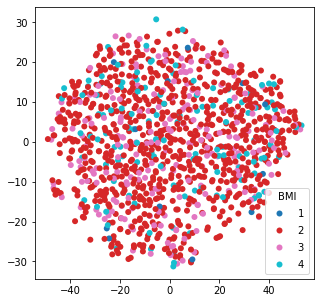

In [122]:
for k in (2,4):
    gmm = GaussianMixture(n_components=k, covariance_type='diag', n_init=10)
    c_pca_gmm = gmm.fit_predict(z_pca)
    draw_embeddings(z_pca_tsne, c_pca_gmm, alpha=1, figsize=(5,5), legend_title="Clusters")

draw_embeddings(z_pca_tsne, asthma_class, alpha=1, figsize=(5,5), legend_title="Asthma")
draw_embeddings(z_pca_tsne, bmi_class, alpha=1, figsize=(5,5), legend_title="BMI")

# DEC

## Build and pre-train the Autoencoder

In [32]:
INPUT_DIM = metabol_exprs.shape[1]  # 221
LATENT_DIM = 4
INTERMEDIATE_DIMS = (64, 32)

EPOCHS = 100
BATCH_SIZE = 32  # 1152 observations
LEARNING_RATE = 1
MOMENTUM = 0.9

model_ae = get_autoencoder_model(INPUT_DIM, LATENT_DIM, INTERMEDIATE_DIMS)

In [33]:
# data points / model parameters ratio:
np.multiply(*metabol_exprs.shape) / (model_ae.encoder.count_params()+model_ae.decoder.count_params())

7.701606316362646

In [34]:
# model_ae.compile(optimizer=keras.optimizers.Adam(),
model_ae.compile(optimizer=keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM),
                 loss="mse")

model_ae.fit(metabol_exprs, metabol_exprs,
             epochs=EPOCHS,
             batch_size=BATCH_SIZE,
             verbose=2,
            )

# model_ae.save_weights("model_weights/dec/pretrained/ae")

model_ae.load_weights("model_weights/dec/pretrained/ae")

Epoch 1/100
36/36 - 1s - loss: 1.0768 - 594ms/epoch - 16ms/step
Epoch 2/100
36/36 - 0s - loss: 0.9488 - 131ms/epoch - 4ms/step
Epoch 3/100
36/36 - 0s - loss: 0.9537 - 113ms/epoch - 3ms/step
Epoch 4/100
36/36 - 0s - loss: 0.9501 - 86ms/epoch - 2ms/step
Epoch 5/100
36/36 - 0s - loss: 0.9365 - 89ms/epoch - 2ms/step
Epoch 6/100
36/36 - 0s - loss: 0.9273 - 92ms/epoch - 3ms/step
Epoch 7/100
36/36 - 0s - loss: 0.9234 - 90ms/epoch - 2ms/step
Epoch 8/100
36/36 - 0s - loss: 0.9198 - 90ms/epoch - 3ms/step
Epoch 9/100
36/36 - 0s - loss: 0.9185 - 122ms/epoch - 3ms/step
Epoch 10/100
36/36 - 0s - loss: 0.9160 - 114ms/epoch - 3ms/step
Epoch 11/100
36/36 - 0s - loss: 0.9138 - 106ms/epoch - 3ms/step
Epoch 12/100
36/36 - 0s - loss: 0.9097 - 91ms/epoch - 3ms/step
Epoch 13/100
36/36 - 0s - loss: 0.9022 - 98ms/epoch - 3ms/step
Epoch 14/100
36/36 - 0s - loss: 0.8973 - 94ms/epoch - 3ms/step
Epoch 15/100
36/36 - 0s - loss: 0.8943 - 90ms/epoch - 3ms/step
Epoch 16/100
36/36 - 0s - loss: 0.8893 - 94ms/epoch - 3ms

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


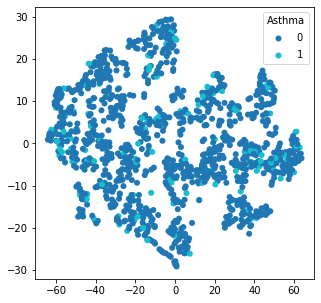

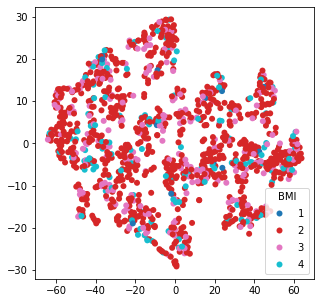

In [35]:
z_ae = model_ae.encode(metabol_exprs)

if LATENT_DIM == 2:
    draw_embeddings(z_ae, asthma_class, alpha=1, figsize=(5,5), legend_title="Asthma")
    draw_embeddings(z_ae, bmi_class, alpha=1, figsize=(5,5), legend_title="BMI")
else:
    tsne = TSNE(n_components=2, init='pca')
    z_dec_tsne = tsne.fit_transform(z_ae)
    draw_embeddings(z_dec_tsne, asthma_class, alpha=1, figsize=(5,5), legend_title="Asthma")
    draw_embeddings(z_dec_tsne, bmi_class, alpha=1, figsize=(5,5), legend_title="BMI")

## Build and fine-tune the DEC (initialize with K-means)

In [101]:
model_ae.load_weights("model_weights/dec/pretrained/ae")

In [102]:
N_CLUSTERS = 4

EPOCHS = 100
LEARNING_RATE = 0.01
MOMENTUM = 0.9
SCHEDULE = 10
DELTA_THRESHOLD = 0.001

model_dec = get_dec_model(model_ae.encoder, N_CLUSTERS)

In [103]:
z_dec = model_dec.encode(metabol_exprs)

kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=30)
kmeans.fit(z_dec)

for weight in model_dec.trainable_weights:
    if weight.name == "centroids:0":
        weight.assign(K.constant(kmeans.cluster_centers_))

Initialize `p`, the auxiliary distribution to compute the clustering loss, and `c_last`, the last cluster assignments to compute the number of points that changed clusters.

In [104]:
p = compute_p(to_categorical(kmeans.labels_))
c_last = kmeans.labels_

In [105]:
def dec_callback(epoch, logs):
    global p
    global c_last
    
    if (epoch+1) % SCHEDULE == 0:
        q = model_dec.soft_assignment(metabol_exprs)
        p = compute_p(q)
        
        c_new = q.numpy().argmax(1)
        delta = compute_delta(c_new, c_last)
        c_last = np.copy(c_new)
        print(f"Delta: {delta:.3f}")
        if (delta < DELTA_THRESHOLD):
            model_dec.stop_training = True
            
callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=dec_callback)

In [106]:
model_dec.compile(optimizer=keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM))
# model_dec.compile(optimizer=keras.optimizers.Adam())

model_dec.fit(metabol_exprs, p,
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              callbacks = callback,
              verbose=2,
             )

model_dec.save_weights("model_weights/dec/finetuned/dec")

model_dec.load_weights("model_weights/dec/finetuned/dec")

Epoch 1/100
36/36 - 1s - loss: 3.2156 - 616ms/epoch - 17ms/step
Epoch 2/100
36/36 - 0s - loss: 2.0991 - 103ms/epoch - 3ms/step
Epoch 3/100
36/36 - 0s - loss: 1.5580 - 111ms/epoch - 3ms/step
Epoch 4/100
36/36 - 0s - loss: 1.3175 - 103ms/epoch - 3ms/step
Epoch 5/100
36/36 - 0s - loss: 1.1492 - 91ms/epoch - 3ms/step
Epoch 6/100
36/36 - 0s - loss: 0.8358 - 96ms/epoch - 3ms/step
Epoch 7/100
36/36 - 0s - loss: 0.6945 - 101ms/epoch - 3ms/step
Epoch 8/100
36/36 - 0s - loss: 0.5472 - 97ms/epoch - 3ms/step
Epoch 9/100
36/36 - 0s - loss: 0.5916 - 105ms/epoch - 3ms/step
Epoch 10/100
Delta: 0.003
36/36 - 0s - loss: 0.5885 - 113ms/epoch - 3ms/step
Epoch 11/100
36/36 - 0s - loss: 0.4208 - 94ms/epoch - 3ms/step
Epoch 12/100
36/36 - 0s - loss: 0.4749 - 98ms/epoch - 3ms/step
Epoch 13/100
36/36 - 0s - loss: 0.4129 - 106ms/epoch - 3ms/step
Epoch 14/100
36/36 - 0s - loss: 0.3580 - 98ms/epoch - 3ms/step
Epoch 15/100
36/36 - 0s - loss: 0.2748 - 120ms/epoch - 3ms/step
Epoch 16/100
36/36 - 0s - loss: 0.2507 - 

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


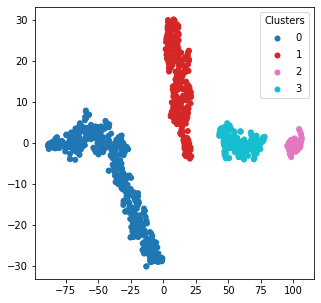

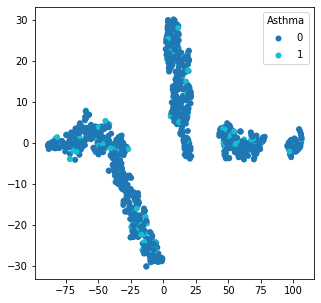

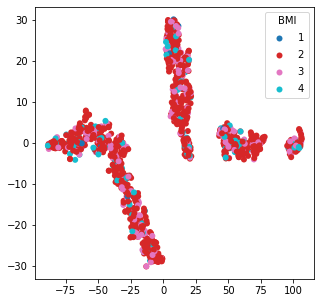

In [107]:
z_dec = model_dec.encode(metabol_exprs)
c_dec = model_dec.classify(metabol_exprs)

if LATENT_DIM == 2:
    draw_embeddings(z_dec, c_dec, alpha=1, figsize=(5,5), legend_title="Clusters")
    draw_embeddings(z_dec, asthma_class, alpha=1, figsize=(5,5), legend_title="Asthma")
    draw_embeddings(z_dec, bmi_class, alpha=1, figsize=(5,5), legend_title="BMI")
else:
    tsne = TSNE(n_components=2, init='pca')
    z_dec_tsne = tsne.fit_transform(z_dec)
    draw_embeddings(z_dec_tsne, c_dec, alpha=1, figsize=(5,5), legend_title="Clusters")
    draw_embeddings(z_dec_tsne, asthma_class, alpha=1, figsize=(5,5), legend_title="Asthma")
    draw_embeddings(z_dec_tsne, bmi_class, alpha=1, figsize=(5,5), legend_title="BMI")

# VaDE

## Build and pre-train the Autoencoder

In [49]:
INPUT_DIM = metabol_exprs.shape[1]  # 221
LATENT_DIM = 4

EPOCHS = 20

model_pretrain, model_vade = get_vade_models(N_CLUSTERS, INPUT_DIM, LATENT_DIM, INTERMEDIATE_DIMS)

LEARNING_RATE = 1e-4
model_pretrain.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                       loss="mse")
# LEARNING_RATE = 1e-4
# MOMENTUM = 0.1
# model_pretrain.compile(optimizer=keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM),
#                        loss=keras.losses.BinaryCrossentropy(reduction='sum'))

model_pretrain.fit(metabol_exprs, metabol_exprs,
                   epochs=EPOCHS,
                   batch_size=BATCH_SIZE,
                   verbose=2,
                  )

model_pretrain.save_weights("model_weights/vade/pretrained/ae")

model_pretrain.load_weights("model_weights/vade/pretrained/ae")

Epoch 1/20
36/36 - 1s - loss: 1.2457 - 721ms/epoch - 20ms/step
Epoch 2/20
36/36 - 0s - loss: 1.2331 - 138ms/epoch - 4ms/step
Epoch 3/20
36/36 - 0s - loss: 1.2025 - 146ms/epoch - 4ms/step
Epoch 4/20
36/36 - 0s - loss: 1.1462 - 129ms/epoch - 4ms/step
Epoch 5/20
36/36 - 0s - loss: 1.0775 - 113ms/epoch - 3ms/step
Epoch 6/20
36/36 - 0s - loss: 1.0206 - 108ms/epoch - 3ms/step
Epoch 7/20
36/36 - 0s - loss: 0.9845 - 109ms/epoch - 3ms/step
Epoch 8/20
36/36 - 0s - loss: 0.9662 - 105ms/epoch - 3ms/step
Epoch 9/20
36/36 - 0s - loss: 0.9572 - 113ms/epoch - 3ms/step
Epoch 10/20
36/36 - 0s - loss: 0.9518 - 122ms/epoch - 3ms/step
Epoch 11/20
36/36 - 0s - loss: 0.9480 - 132ms/epoch - 4ms/step
Epoch 12/20
36/36 - 0s - loss: 0.9448 - 126ms/epoch - 3ms/step
Epoch 13/20
36/36 - 0s - loss: 0.9417 - 111ms/epoch - 3ms/step
Epoch 14/20
36/36 - 0s - loss: 0.9382 - 100ms/epoch - 3ms/step
Epoch 15/20
36/36 - 0s - loss: 0.9337 - 117ms/epoch - 3ms/step
Epoch 16/20
36/36 - 0s - loss: 0.9281 - 95ms/epoch - 3ms/step
E

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


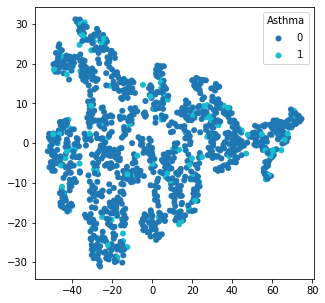

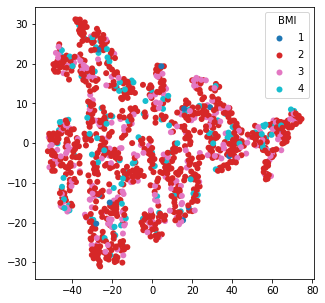

In [80]:
z_pretrain = model_pretrain.encode(metabol_exprs)

if LATENT_DIM == 2:
    draw_embeddings(z_pretrain, phenotype['hs_asthma'], alpha=1, figsize=(5,5), legend_title="Asthma")
    draw_embeddings(z_pretrain, phenotype['hs_bmi_c_cat'], alpha=1, figsize=(5,5), legend_title="BMI")
else:
    tsne = TSNE(n_components=2, init='pca')
    z_vade_tsne = tsne.fit_transform(z_pretrain)
    draw_embeddings(z_vade_tsne, phenotype['hs_asthma'], alpha=1, figsize=(5,5), legend_title="Asthma")
    draw_embeddings(z_vade_tsne, phenotype['hs_bmi_c_cat'], alpha=1, figsize=(5,5), legend_title="BMI")

In [93]:
model_pretrain.load_weights("model_weights/vade/pretrained/ae")

In [94]:
z_vade = model_vade.encode_only_mu(metabol_exprs)

gmm = GaussianMixture(n_components=N_CLUSTERS, covariance_type='diag', n_init=30)
gmm.fit(z_vade)

for weight in model_vade.trainable_weights:
    if weight.name == "pi:0":
        weight.assign(K.log(K.constant(gmm.weights_)))
    elif weight.name == "mu:0":
        weight.assign(K.constant(gmm.means_))
    elif weight.name == "logvar:0":
        weight.assign(K.log(K.constant(gmm.covariances_)))

In [95]:
def scheduler(epoch, lr):
    if (epoch+1) % SCHEDULE == 0:
        lr = lr * 0.9
    return lr

callback = [tf.keras.callbacks.LearningRateScheduler(scheduler),]

In [96]:
EPOCHS = 50
SCHEDULE = 10

# LEARNING_RATE = 1e-6
# model_vade.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

LEARNING_RATE = 1e-8
MOMENTUM = 0.1
model_vade.compile(optimizer=keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM))

model_vade.fit(metabol_exprs,
               epochs=EPOCHS,
               batch_size=BATCH_SIZE,
               callbacks = callback,
               verbose=2,
              )

model_vade.save_weights("model_weights/vade/finetuned/vade")

model_vade.load_weights("model_weights/vade/finetuned/vade")

Epoch 1/50
36/36 - 1s - loss: -2.7369e+02 - lr: 1.0000e-08 - 1s/epoch - 38ms/step
Epoch 2/50
36/36 - 0s - loss: -2.7769e+02 - lr: 1.0000e-08 - 152ms/epoch - 4ms/step
Epoch 3/50
36/36 - 0s - loss: -2.7651e+02 - lr: 1.0000e-08 - 159ms/epoch - 4ms/step
Epoch 4/50
36/36 - 0s - loss: -2.7651e+02 - lr: 1.0000e-08 - 159ms/epoch - 4ms/step
Epoch 5/50
36/36 - 0s - loss: -2.7712e+02 - lr: 1.0000e-08 - 182ms/epoch - 5ms/step
Epoch 6/50
36/36 - 0s - loss: -2.7694e+02 - lr: 1.0000e-08 - 166ms/epoch - 5ms/step
Epoch 7/50
36/36 - 0s - loss: -2.7809e+02 - lr: 1.0000e-08 - 153ms/epoch - 4ms/step
Epoch 8/50
36/36 - 0s - loss: -2.7692e+02 - lr: 1.0000e-08 - 150ms/epoch - 4ms/step
Epoch 9/50
36/36 - 0s - loss: -2.7668e+02 - lr: 1.0000e-08 - 158ms/epoch - 4ms/step
Epoch 10/50
36/36 - 0s - loss: -2.7779e+02 - lr: 9.0000e-09 - 159ms/epoch - 4ms/step
Epoch 11/50
36/36 - 0s - loss: -2.7783e+02 - lr: 9.0000e-09 - 153ms/epoch - 4ms/step
Epoch 12/50
36/36 - 0s - loss: -2.7662e+02 - lr: 9.0000e-09 - 161ms/epoch - 

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


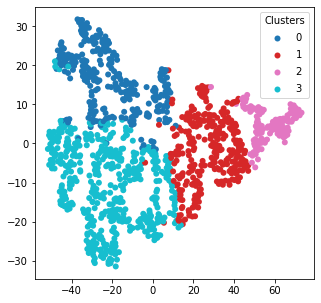

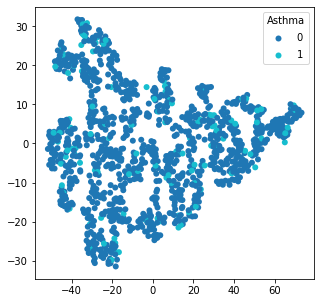

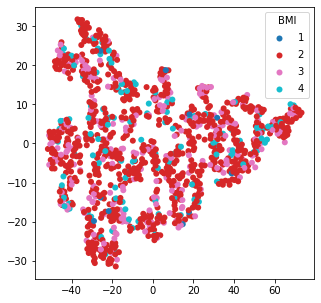

In [97]:
z_vade = model_vade.encode_only_mu(metabol_exprs)
c_vade = model_vade.classify(metabol_exprs)

if LATENT_DIM == 2:
    draw_embeddings(z_vade, c_vade, alpha=1, figsize=(5,5), legend_title="Clusters")
    draw_embeddings(z_vade, phenotype['hs_asthma'], alpha=1, figsize=(5,5), legend_title="Asthma")
    draw_embeddings(z_vade, phenotype['hs_bmi_c_cat'], alpha=1, figsize=(5,5), legend_title="BMI")
else:
    tsne = TSNE(n_components=2, init='pca')
    z_vade_tsne = tsne.fit_transform(z_vade)
    draw_embeddings(z_vade_tsne, c_vade, alpha=1, figsize=(5,5), legend_title="Clusters")
    draw_embeddings(z_vade_tsne, phenotype['hs_asthma'], alpha=1, figsize=(5,5), legend_title="Asthma")
    draw_embeddings(z_vade_tsne, phenotype['hs_bmi_c_cat'], alpha=1, figsize=(5,5), legend_title="BMI")

# Compare the cluster assignments

## DEC vs VaDE

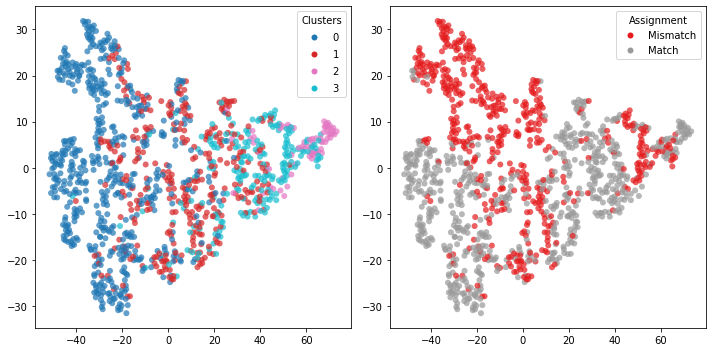

In [108]:
# Compare the DEC cluster assignments over the VaDE embeddings
draw_clusters_assignments(z_vade_tsne, c_vade, c_dec, figsize=(10,5), alpha=0.7)

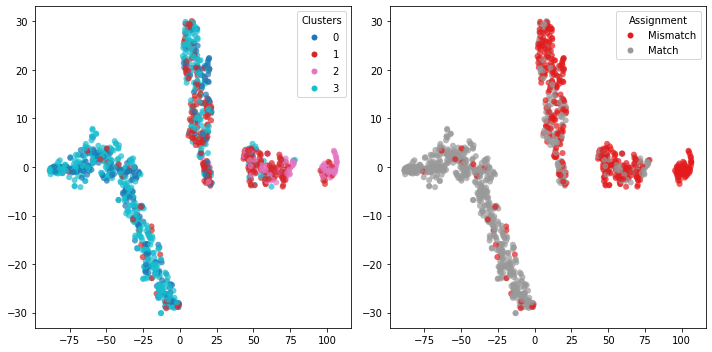

In [109]:
# Compare the VaDE cluster assignments over the DEC embeddings
draw_clusters_assignments(z_dec_tsne, c_dec, c_vade, figsize=(10,5), alpha=0.7)

{'Acc': 0.5555555555555556,
 'ARI': 0.22845531713157732,
 'AMI': 0.2834479193626212,
 'Sil': 0.12400022}

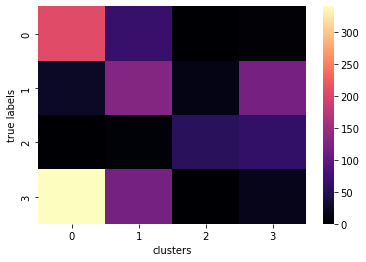

In [128]:
evaluate_clustering(z_vade_tsne, c_vade, c_dec)

## DEC vs PCA (K-means)

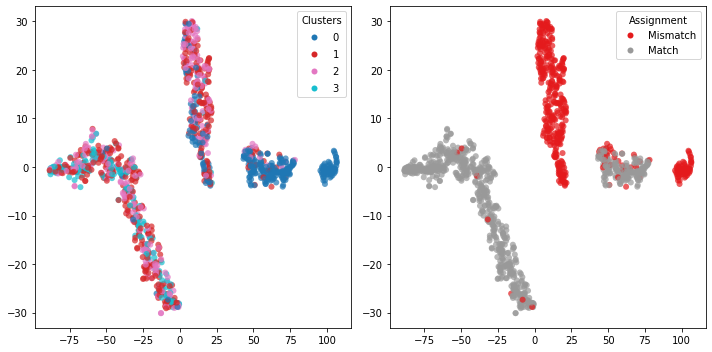

In [125]:
# Compare the PCA cluster assignments over the DEC embeddings
draw_clusters_assignments(z_dec_tsne, c_dec, c_pca_kmeans, figsize=(10,5), alpha=0.7)

{'Acc': 0.6336805555555556,
 'ARI': 0.374851831136267,
 'AMI': 0.3726699898830442,
 'Sil': 0.057315417}

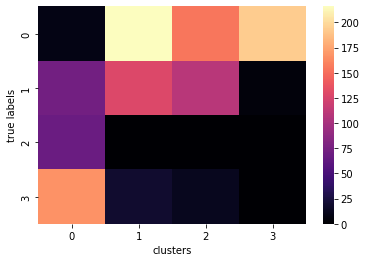

In [126]:
evaluate_clustering(z_dec_tsne, c_dec, c_pca_kmeans)

## VaDE vs PCA (K-means)

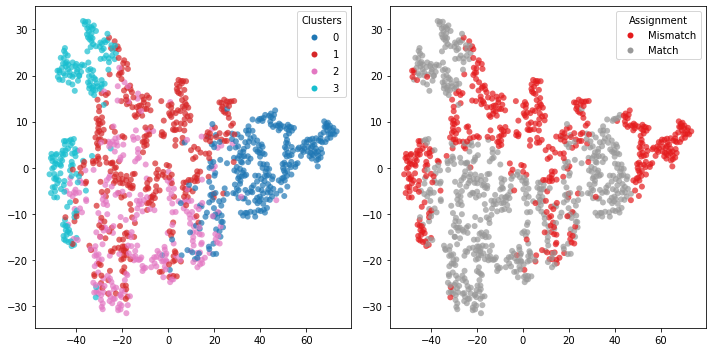

In [131]:
# Compare the PCA cluster assignments over the VaDE embeddings
draw_clusters_assignments(z_vade_tsne, c_vade, c_pca_kmeans, figsize=(10,5), alpha=0.7)

{'Acc': 0.5755208333333334,
 'ARI': 0.26512268811663914,
 'AMI': 0.3634527626701382,
 'Sil': 0.21608114}

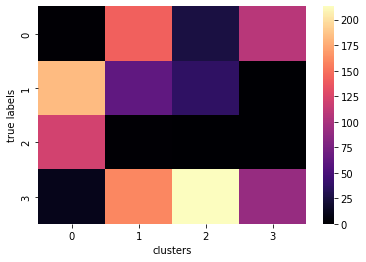

In [132]:
evaluate_clustering(z_vade_tsne, c_vade, c_pca_kmeans)

## VaDE vs PCA (GMM)

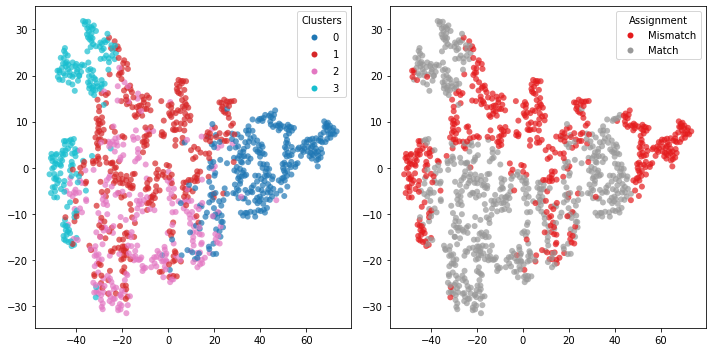

In [123]:
# Compare the PCA cluster assignments over the VaDE embeddings
draw_clusters_assignments(z_vade_tsne, c_vade, c_pca_gmm, figsize=(10,5), alpha=0.7)

{'Acc': 0.5755208333333334,
 'ARI': 0.26512268811663914,
 'AMI': 0.3634527626701382,
 'Sil': 0.21608114}

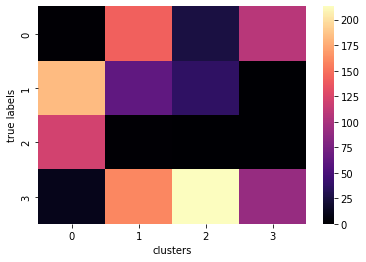

In [127]:
evaluate_clustering(z_vade_tsne, c_vade, c_pca_gmm)

# Discussion

The found clusters don't seem to explain the categorical groups of the phenotype we explored.
Also, there is little agreement between the clusters found with the different methods.

This doesn't seem to be very promising...